# Optimization of a chirped dielectric structure using Nevergrad and PyMoosh

This file shows how to use the Chirped function implemented in the Photonics package of Nevergrad.

We first import all the modules needed. 

In [64]:
import numpy as np # to make arrays
import matplotlib.pyplot as plt # to trace figures
import nevergrad as ng # to run the optimization
from nevergrad.functions import photonics # to define the cost function
from PyMoosh import * # to analyse the result

## Optimisation using Nevergrad

### Define the cost function

The first stage of any optimization os to define the objective, usually on the form of a cost function. This cost function can be home-fabricated, for the example above we directly use the `Chirped` function of the module Photonics implemented in Nevergrad. This function is describes more precisely in https://github.com/facebookresearch/nevergrad/blob/main/nevergrad/functions/photonics/photonics.py and consist to optimize a multilayer with num_layers layers constituted of an alternance of two dielectric materials. The objective is to reflect 50 wavelengths between 500 and 800 nm. The substrate is the higher refractive index material and the superstrate is air. An impedance formalism is used to compute the reflection coefficient of the structure. 

In [65]:
num_layers = 30 # number of layers in the structure 
func = photonics.Photonics(
    "chirped",
    num_layers
) #cost function stored in Photonics module of Nevergrad

### Define the parametrization

For each optimization we need to define some `parametrization` defining the type of variables to optimize. Those variables can be continuous or discrete, and of any dimension. Here, we let the variables take values between 10 and 300 nm (that is coherent to optimize thicknesses of the multilayer). As we using essentially evolutionary algorithms, some `child` is created. 

Here, we define the `reference child` by a suite of layers of 150 nm, the central part of our optimization domain. Otherwise, the child is by default a 0s vector and the optimization will not run because the child in not in the optimization domain.  

In [66]:
# The parameters to optimized are stored in a 1D array of number layers values 
parametrization = ng.p.Array(shape=(num_layers,))

# We create an initialized structure. The values are 0 by default.  
child = parametrization.spawn_child() 
print("value of the child before: ", child.value)

# We change the initial values from 0 to 150 nm, as we don't want layers of 0 nm
# thicknesses
child.value = np.tile([150,150],int(num_layers/2))
print("value of the child after : ", child.value)

# We store this structure as the initialized structures for the next steps of 
# optimization
parametrization.value = child.value

# We set the lower and upper values authorized for the thicknesses 
parametrization = parametrization.set_bounds(lower=10, upper=300)

value of the child before:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
value of the child after :  [150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150
 150 150 150 150 150 150 150 150 150 150 150 150]


### Run the optimization

We can use many algorithms by using Nevergrad. Here, we use `DE`, and we give a `budget` of 1000 to run the optimization. This `budget` is the number of times the cost function will be calculated. The optimization finishes when all the budget is used. We need to ensure that the chosen budget is sufficient to let the algorithm converges to a solution. 

It is in the loop that the optimization performs. The `ask()` function generates some new structure, and we compute the `loss` (the value of the cost function) of this structure using the `func(x.value)` function. The optimization has in memory all the structures tested, so by using `recommendation()` method we ask wich structure is the best for now. The `loss2` array save the values of the best cost functions obtained after each iteration of the algorithm. 

`best` is a vector with the thicknesses of the structure.

`cf_best` is a vector with the associate cost function value. 

In [67]:
# We set the optimizer "DE" with a budget of 100 evaluations of the cost function
# and the parametrization defined above
optim = ng.optimizers.registry["DE"](parametrization, budget = 100000)

# We initialized two arrays to store the data
loss = np.empty(optim.budget)
loss2 = np.empty(optim.budget)

# for each iteration of the optimization, we create a structure x, we compute its 
# cost function and store it in the 'loss' and 'loss2' arrays.
for i in range(optim.budget):
    x = optim.ask() # creation of a structure
    loss[i] = func(x.value) # compute the cost function of the 'x' structure
    optim.tell(x, loss[i]) # i don't know why this line is useful, but it is. If 
    # it is commented, the code doesn't run.
    reco2 = optim.provide_recommendation() # provide the best structure computed 
    # for now
    loss2[i] = func(reco2.value) # store the best cost function obtained for now

best = reco2.value # store the best structure obtained with the optimization process
cf_best = func(best) # store the best cost function obtained with the optimization
# process

### Verification of the convergence of the optimization

Here we check if the optimization has converged. We represent of a graph the cost function of the best structures in function of the iteration of the algorithms. We can so check if the budget is sufficient or if we need to increase it.  

best =  [ 92.60673525 211.50995782 289.78547816 134.23050957  98.83025957
  97.35592281  71.88978576 110.14640197  91.35350622  83.47582914
  84.27198887 128.7716653   84.43728238 139.51680565  67.56122336
 194.22368844  75.68046478 167.334954    74.13589442 224.75950354
 101.01071445  75.96739316 112.90289907 110.33428275  69.8478374
 133.74958314 259.50439608 148.36194161 124.82097783 205.13783763]
best cost function =  0.42294494798919013


Text(0.5, 1.0, 'Convergence curve of the optimization')

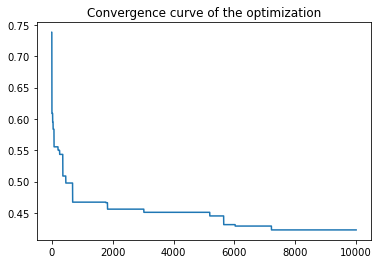

In [68]:
print("best = ", best) # display the best structure
print("best cost function = ", cf_best) # display the best cost function value

# display the convergence curve of the optimization. 
# The value of the convergence have to stuck. If not, the budget is not sufficient
plt.figure(1)
plt.plot(loss2)
plt.title("Convergence curve of the optimization")

## Analyse of the result using Moosh

### Definition of the structure

In [69]:
# We set the permittivities of the materials used. 
# Those materials are imposed in the Chirped() function in Photonics package of 
# Nevergrad.
materials = [1., 1.4142135623730951**2, 1.7320508075688772**2]

# We define the thicknesses of the multilayers. They are given by the 'best' 
# structure optimized. We add a upperstrate of air and a substrate of the upper 
# permittivity material. 
list = [2,1] # our structure begin with the upper RI material
layer_type = [0] + (int(num_layers/2))*list + [2] # our structure is an alternance 
# of the upper and lower RI materials, with an air incident medium and a upper RI 
# material substrate
thickness = [0] + best.tolist() + [0]

# We define the all structure with PyMoosh package
multilayers = Structure(materials,layer_type,thickness)

### Visualization of the spectrum

We want to visualize the reflection spectrum of our optimized structure. We use the PyMoosh package. 

For using the `Spectrum()` function we need to define the incidence angle of the excitation plane wave, its polarization (0 for TE or s-polarization, 1 otherwise), and the range of wavelengths we want to compute. 

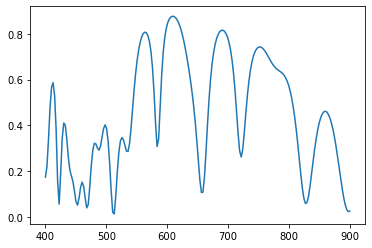

In [70]:
incidence = 0 # angle of incidence (in degrees)
polarization = 0 # 0 for TE (or s-polarization), 1 otherwise
wl_min = 400 # lower value of wavelength spectrum, in nanometers
wl_max = 900 # upper value of wavelength spectrum, in nanometers
n_points = 200 # number of wavelngths computed to represent the spectrum

[wl,r,t,R,T] = Spectrum(multilayers, incidence,polarization,wl_min,wl_max,n_points)

# visualization of the reflectance of the structure
plt.figure(2)
plt.plot(wl,R)

### Visualization of the structure

We want to visualize our optimized structure. We use the PyMoosh package. 

For using the `Visu_struct` function we need to define the wavelength excitation of the structure as sometimes, the permittivities values depend on the wavelength.

<Figure size 432x288 with 0 Axes>

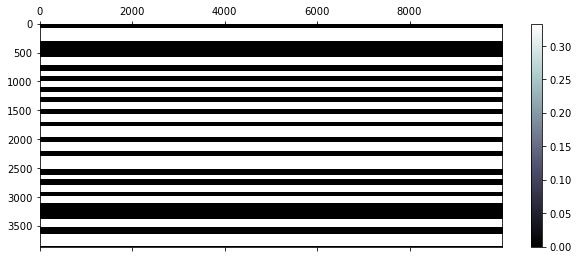

In [71]:
M = Visu_struct(multilayers,600)

plt.figure(3)
plt.matshow(M, cmap = 'bone', aspect = 'auto') 
plt.colorbar() 
plt.show()
# The lower RI material is represented in black, and the upper RI material is in 
# white. It is not coherent with a multilayer beggining with a upper RI material as 
# attended. Be careful.

## Visualization of the field

It is first necessary to define a calculation window, as well as an incident beam.

-For the window, the class `Window` asks to provide the horizontal size of the window, the position of the incident beam with respect to the window (0 = all on the left, 1 = all on the right), the size one pixel horizontal and one pixel vertical size.

-For the beam, the class `Beam` asks to provide the wavelength, the angle of incidence, the polarization (0=TE,1=TM) and the horizontal waist.

Here, we ask the field map when we excite the optimized structure with a 600 nm wavelength with an incidence angle of 45 degrees in polarization TE (s polarization) and with a waist beam of 10 times the wavelength. 



Pixels horizontally: 1400
Incidence in degrees: 45.0
E//, TE, s polarization
Pixels vertically: 114


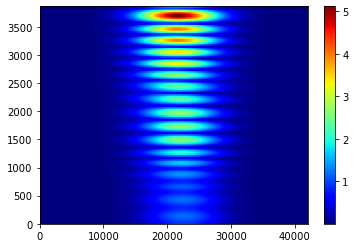

In [72]:
wavelength = 600 # wavelength of the incident beam
window = Window(70*wavelength, 0.5, 30., 30.)
beam = Beam(wavelength, np.pi/4,0,10*wavelength)

E = field(multilayers, beam, window)

plt.figure(4)
plt.imshow(abs(E),cmap='jet',extent=[0,window.width,0,sum(multilayers.thickness)],aspect='auto')
plt.colorbar()